In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
from torchsummary import summary

In [2]:
file_path = r'C:\Users\CHOI.DESKTOP-R51MDOU\OneDrive - 가천대학교\바탕 화면\Coding\AI Introduction\diabetes.csv'
df = pd.read_csv(file_path)
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [3]:
# 데이터와 타겟 분리
X = df.drop('Outcome', axis = 1).values
y = df['Outcome'].values

In [4]:
# 데이터의 정규화
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 특성과 타겟 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

In [5]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, 

((614, 8), (154, 8), (614,), (154,))

In [6]:
# pytorch tensor로 변환
X_train = torch.tensor(X_train, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.int64)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.int64)

In [7]:
# 원-핫 엔코딩.
y_train = F.one_hot(y_train, num_classes = 2).float()

In [8]:
# DataLoader 생성

train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle=False)

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([614, 8]),
 torch.Size([154, 8]),
 torch.Size([614, 2]),
 torch.Size([154]))

In [10]:
# model 정의
class DiabetesDense(nn.Module):
    def __init__(self):
        super(DiabetesDense, self).__init__()
        self.fc1 = nn.Linear(8, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, 8)
        self.fc4 = nn.Linear(8, 32)
        self.fc5 = nn.Linear(32, 2)  # 2 classes in the dataset
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Initialize the model, loss function, and optimizer
model = DiabetesDense()

In [11]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [12]:
# loss와 정확도 저장용 변수
train_losses = []
test_accuracies = []

# 학습 루프
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss over an epoch
    train_losses.append(running_loss / len(train_dataloader))

    # Evaluate on test data
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("학습 완료.")

Epoch 1/30, Loss: 0.6911, Accuracy: 69.48%
Epoch 2/30, Loss: 0.6568, Accuracy: 69.48%
Epoch 3/30, Loss: 0.6064, Accuracy: 69.48%
Epoch 4/30, Loss: 0.5518, Accuracy: 77.92%
Epoch 5/30, Loss: 0.5014, Accuracy: 77.27%
Epoch 6/30, Loss: 0.4806, Accuracy: 76.62%
Epoch 7/30, Loss: 0.4928, Accuracy: 75.32%
Epoch 8/30, Loss: 0.4784, Accuracy: 75.97%
Epoch 9/30, Loss: 0.4650, Accuracy: 75.97%
Epoch 10/30, Loss: 0.4659, Accuracy: 77.92%
Epoch 11/30, Loss: 0.4526, Accuracy: 76.62%
Epoch 12/30, Loss: 0.4765, Accuracy: 74.68%
Epoch 13/30, Loss: 0.4570, Accuracy: 78.57%
Epoch 14/30, Loss: 0.4692, Accuracy: 75.97%
Epoch 15/30, Loss: 0.4452, Accuracy: 78.57%
Epoch 16/30, Loss: 0.4452, Accuracy: 77.27%
Epoch 17/30, Loss: 0.4477, Accuracy: 77.92%
Epoch 18/30, Loss: 0.4386, Accuracy: 77.92%
Epoch 19/30, Loss: 0.4309, Accuracy: 77.92%
Epoch 20/30, Loss: 0.4365, Accuracy: 77.27%
Epoch 21/30, Loss: 0.4233, Accuracy: 77.27%
Epoch 22/30, Loss: 0.4223, Accuracy: 77.92%
Epoch 23/30, Loss: 0.4317, Accuracy: 77.9

In [13]:
# Evaluation
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

# Calculate specificity for each class
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')

Confusion Matrix:
[[88 19]
 [17 30]]
F1 Score: 0.77
Precision: 0.77
Recall: 0.77
Specificity: 0.73


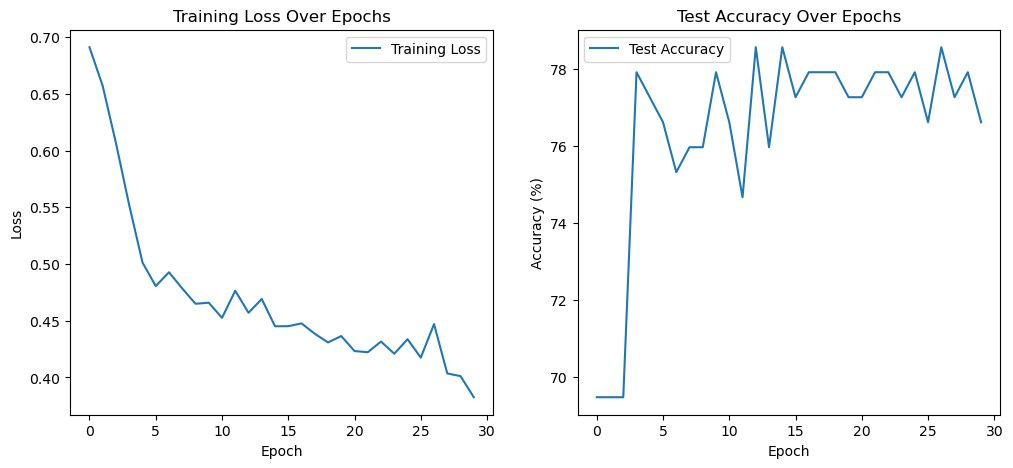

In [14]:
# Plot the loss and accuracy
plt.figure(figsize = (12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label = 'Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label = 'Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()

In [15]:
df.drop(columns = 'Outcome')

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33
...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63
764,2,122,70,27,0,36.8,0.340,27
765,5,121,72,23,112,26.2,0.245,30
766,1,126,60,0,0,30.1,0.349,47


In [18]:
# 데이터와 타겟 분리
X = df.drop('BMI', axis = 1).values
y = df['BMI'].values

In [19]:
# 데이터의 정규화
scaler = StandardScaler()
X = scaler.fit_transform(X)

# 특성과 타겟 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [20]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, 

((614, 8), (154, 8), (614,), (154,))

In [21]:
# pytorch tensor로 변환
X_train = torch.tensor(X_train, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.int64)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_test = torch.tensor(y_test, dtype = torch.int64)

In [22]:
# DataLoader 생성

train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle = False)

In [23]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([614, 8]),
 torch.Size([154, 8]),
 torch.Size([614]),
 torch.Size([154]))

In [24]:
# model 정의
class DiabetesDenseRegression(nn.Module):
    def __init__(self):
        super(DiabetesDenseRegression, self).__init__()
        self.fc1 = nn.Linear(8, 16)
        self.fc2 = nn.Linear(16, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 1)  
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

# Initialize the model, loss function, and optimizer
model = DiabetesDenseRegression()

In [25]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [26]:
# loss와 평가 지표 저장용 변수
train_losses = []
test_losses = []
pred_value = torch.tensor([], dtype=torch.float)
real_value = torch.tensor([], dtype=torch.float)

# 학습 루프
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs).squeeze()  # 모델 출력 크기 조정
        labels = labels.float().squeeze()  # 레이블을 Float 타입으로 변환 및 크기 조정
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss over an epoch
    train_losses.append(running_loss / len(train_dataloader))

    # Evaluate on test data
    model.eval()
    pred_value = torch.tensor([], dtype=torch.float)
    real_value = torch.tensor([], dtype=torch.float)
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs).squeeze()  # 모델 출력 크기 조정
            labels = labels.float().squeeze()  # 레이블을 Float 타입으로 변환 및 크기 조정
            pred_value = torch.cat((pred_value, outputs), 0)
            real_value = torch.cat((real_value, labels), 0)
            test_loss += criterion(outputs, labels).item()

        # Calculate average test loss
        test_losses.append(test_loss / len(test_dataloader))

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}")

print("학습 완료.")


Epoch 1/30, Train Loss: 1062.2100, Test Loss: 978.2273
Epoch 2/30, Train Loss: 1046.3906, Test Loss: 933.7642
Epoch 3/30, Train Loss: 937.3067, Test Loss: 767.5803
Epoch 4/30, Train Loss: 636.8668, Test Loss: 332.0496
Epoch 5/30, Train Loss: 199.7881, Test Loss: 99.3673
Epoch 6/30, Train Loss: 105.9860, Test Loss: 73.5384
Epoch 7/30, Train Loss: 81.8474, Test Loss: 71.2044
Epoch 8/30, Train Loss: 74.4420, Test Loss: 69.7667
Epoch 9/30, Train Loss: 69.8211, Test Loss: 68.3796
Epoch 10/30, Train Loss: 66.2824, Test Loss: 66.7968
Epoch 11/30, Train Loss: 64.8270, Test Loss: 65.7655
Epoch 12/30, Train Loss: 62.1741, Test Loss: 63.7355
Epoch 13/30, Train Loss: 59.1930, Test Loss: 62.9261
Epoch 14/30, Train Loss: 59.6268, Test Loss: 61.8190
Epoch 15/30, Train Loss: 61.1936, Test Loss: 60.6779
Epoch 16/30, Train Loss: 54.6204, Test Loss: 60.9020
Epoch 17/30, Train Loss: 53.4019, Test Loss: 59.2537
Epoch 18/30, Train Loss: 51.0881, Test Loss: 58.0268
Epoch 19/30, Train Loss: 50.2602, Test Loss

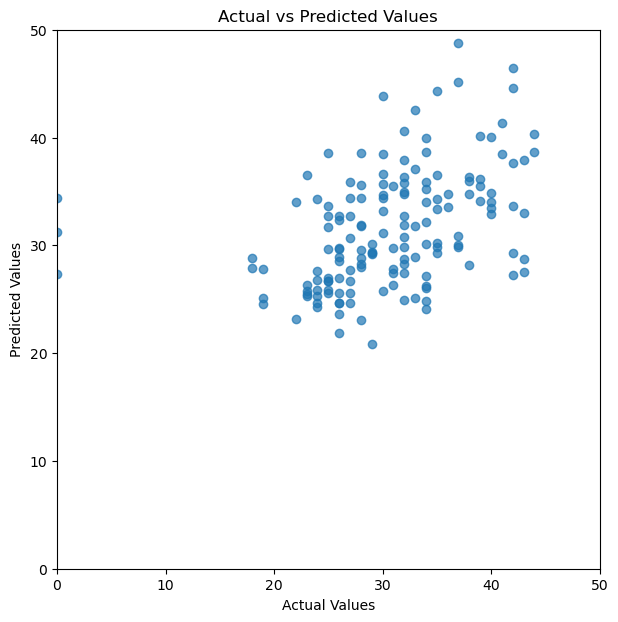

In [28]:
# 예측 값과 실제 값 저장용 변수 초기화
pred_value = torch.tensor([], dtype=torch.float)
real_value = torch.tensor([], dtype=torch.float)

# 테스트 데이터셋에서 예측 값과 실제 값 추출
model.eval()
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs).squeeze()  # 모델 출력 크기 조정
        labels = labels.float().squeeze()  # 레이블을 Float 타입으로 변환 및 크기 조정
        pred_value = torch.cat((pred_value, outputs), 0)
        real_value = torch.cat((real_value, labels), 0)

# 예측 값과 실제 값 산점도 그리기
plt.figure(figsize = (7, 7))
plt.xlim(0, 50)
plt.ylim(0, 50)
plt.scatter(real_value.numpy(), pred_value.numpy(), alpha=0.7)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.show()
